# PART II
The purpose of this document is to split the forcing data and the velocity results for a single member. First, we load in the relevant libraries and packages.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2022-11-28 16:07:06.332022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def prepare_y(data_sets,time_reindex=True):
    if isinstance(data_sets, str):
        data_sets = [data_sets]
        
    Y_all = []
    length_all = []
    
    for file in data_sets:
        data_raw = xr.open_dataset(f"raw_data/velsurf_{file}_100yr_d1.nc",decode_times=False)
        data = data_raw.isel(time=np.arange(1000,len(data_raw.time),1)).drop(['lon','lat'])
        Y_all.append(data)
        length_all.append(len(data.time))
    
    length_all = np.array(length_all)
    Y = xr.concat(Y_all,dim='time')
    # Y = xr.concat([xr.open_dataset(data_path + f"outputs_{file}.nc") for file in data_sets], dim='time').mean("member")
    Y = Y.transpose('time','x', 'y')
    if time_reindex:
        Y = Y.assign_coords(time=np.arange(len(Y.time)))
    
    return Y, length_all

def prepare_x(data_sets,time_range,time_reindex=True):
    if isinstance(data_sets, str):
        data_sets = [data_sets]
        
    X_all      = []
    length_all = []
    
    for value in data_sets:
        data_raw = xr.open_dataset('timeseries_edc-wdc_temp.nc',decode_times=False)
        data = data_raw.interp(time=time_range)
        data['param'] = (['time'],value*np.ones(len(time_range)))
        X_all.append(data)
        length_all.append(len(data.time))
    
    X = xr.concat(X_all,dim='time')
    length_all = np.array(length_all)
    # X = xr.concat([xr.open_dataset(data_path + f"inputs_{file}.nc") for file in data_sets], dim='time')
    if time_reindex:
        X = X.assign_coords(time=np.arange(len(X.time)))

    return X, length_all

In [18]:
y_train_xr,y_length = prepare_y(['240','242','243'])
y_test_xr,_ = prepare_y(['241'],time_reindex=False)
y_test_xr['time'] = y_test_xr.time/31536000
year_range = y_test_xr.time

X_train_xr,X_length = prepare_x([1e20,2.5e21,1e22],year_range)
X_test_xr,_ = prepare_x([5e20],year_range,time_reindex=False)

In [19]:
X_train_df = pd.DataFrame({"delta_T": X_train_xr["delta_T"].data,
                           "param": X_train_xr["param"].data
                          }, index=X_train_xr["delta_T"].coords['time'].data)

X_test_df  = pd.DataFrame({"delta_T": X_test_xr["delta_T"].data,
                           "param": X_test_xr["param"].data
                          }, index=X_test_xr["delta_T"].coords['time'].data)


y_train_df = y_train_xr["velsurf_mag"].stack(dim=["x", "y"])
y_train_df = pd.DataFrame(y_train_df.to_pandas())

In [20]:
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape,X_test.shape)

(756, 2) (756, 145161) (252, 2)


In [21]:
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    y_pred = y_pred[y_true >=0]
    y_true = y_true[y_true >=0]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

In [22]:
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.01
minibatch_size = 64
model_num      = 1

In [23]:
model = Sequential()

model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 4th hidden layer
model.add(Dense(y_train.shape[1],  activation='linear')) # the output layer


model.compile(loss=custom_rmse,optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                192       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 145161)            9435465   
                                                                 
Total params: 9,448,137
Trainable params: 9,448,137
Non-trainable params: 0
_________________________________________________________________


In [24]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/50
10/10 [==============================] - 1s 52ms/step - loss: 239.0392 - val_loss: 314.1229
Epoch 2/50
10/10 [==============================] - 0s 27ms/step - loss: 213.6250 - val_loss: 249.1381
Epoch 3/50
10/10 [==============================] - 0s 28ms/step - loss: 167.1634 - val_loss: 228.9270
Epoch 4/50
10/10 [==============================] - 0s 28ms/step - loss: 158.8446 - val_loss: 201.4661
Epoch 5/50
10/10 [==============================] - 0s 28ms/step - loss: 152.4675 - val_loss: 209.5943
Epoch 6/50
10/10 [==============================] - 0s 26ms/step - loss: 147.1903 - val_loss: 263.0210
Epoch 7/50
10/10 [==============================] - 0s 27ms/step - loss: 144.6207 - val_loss: 338.6520
Epoch 8/50
10/10 [==============================] - 0s 27ms/step - loss: 143.4762 - val_loss: 302.2231
Epoch 9/50
10/10 [==============================] - 0s 27ms/step - loss: 138.9512 - val_loss: 290.6721
Epoch 10/50
10/10 [==============================] - 0s 26ms/step - loss:

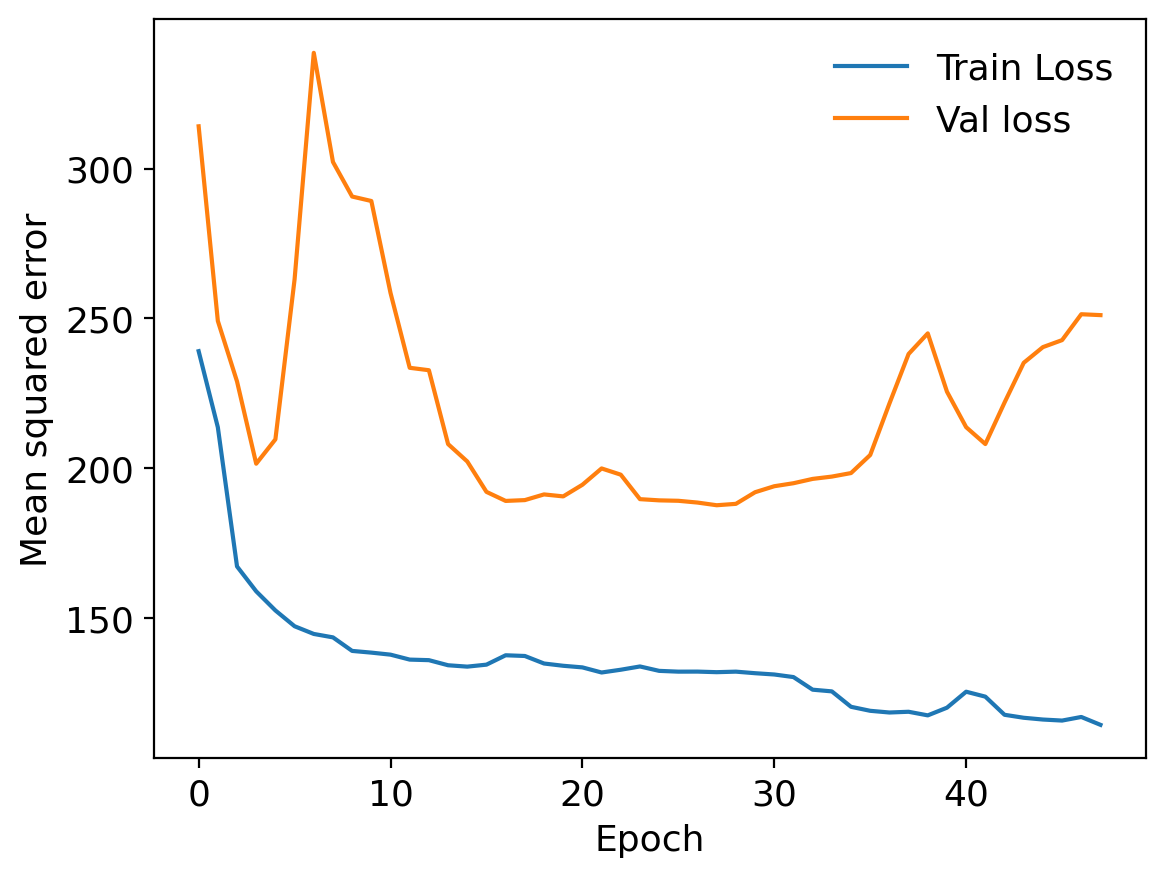

In [25]:
plot_history(history)

In [26]:
y_test_df = pd.DataFrame(y_test_xr.velsurf_mag.stack(dim=["y", "x"]).to_pandas())

In [27]:
y_test = y_test_df.to_numpy()

In [28]:
y_test_pre = model.predict(X_test)


8/8 [==============================] - 0s 2ms/step


In [29]:
y_test_pre_rs = y_test_pre.reshape(y_test_df.index.values.shape[0],y_test_df.columns.levels[1].shape[0],y_test_df.columns.levels[0].shape[0])

y_test_pre_xr = xr.Dataset(coords={'time': y_test_df.index.values, 
                               'x': y_test_df.columns.levels[1].values, 
                               'y': y_test_df.columns.levels[0].values},
                       data_vars=dict(velsurf_mag=(['time', 'y', 'x'], y_test_pre_rs)))

In [30]:
y_true =  y_test_df.unstack().to_xarray()

In [31]:
y_test_pre_xr = y_test_pre_xr + y_true - y_true

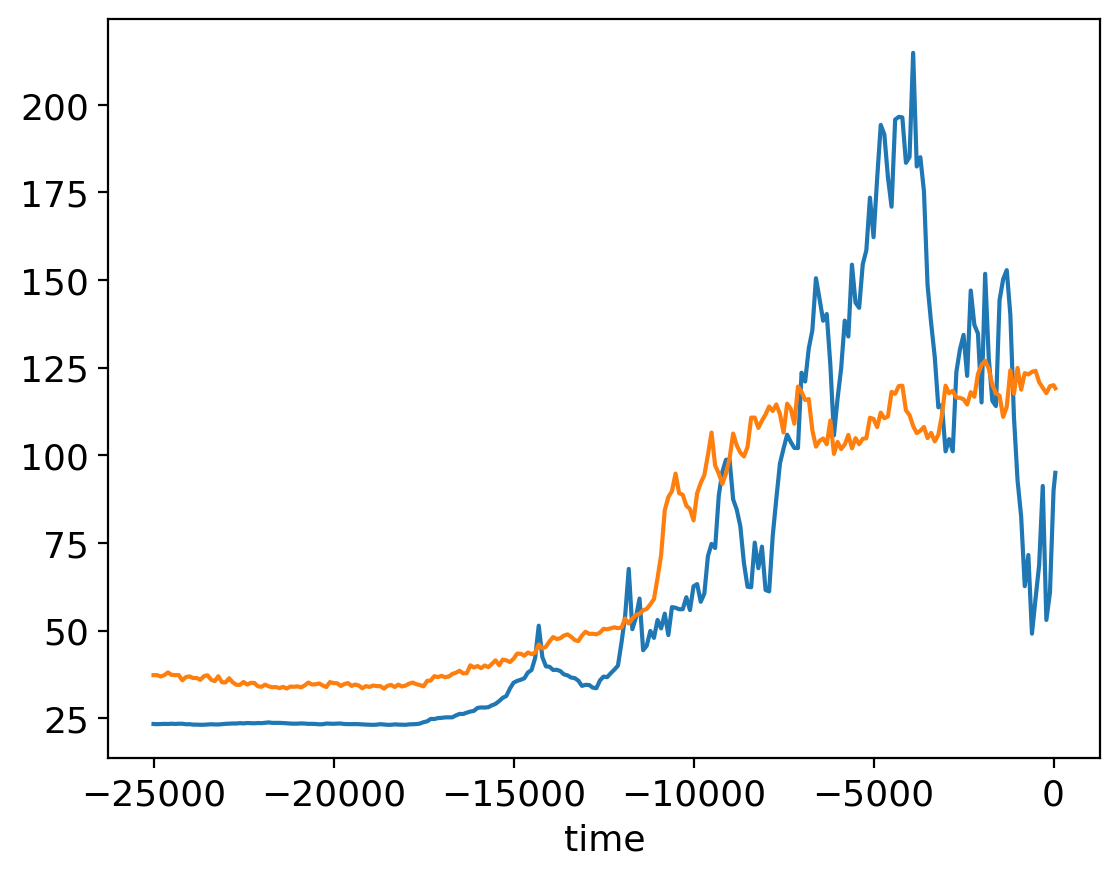

In [32]:
y_test_pre_xr.velsurf_mag.mean(dim=['x','y']).plot()
y_true.mean(dim=['x','y']).plot()